## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [192]:
import json
import numpy as np
import pandas as pd
from typing import Counter
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajsv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [193]:
# Opening JSON file
with open('complaints-2021-05-14_08_16.json') as f:
    # read json file content as a dictionary
    data = json.load(f)

# Converting to pandas dataframe
df=pd.json_normalize(data)

# df = df.head(1000)


## Data preparation

In [194]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [195]:
#print the column names
df.columns


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [196]:
#Assign new column names
df.columns = [
       'index', 'type', 'id', 'score', 'tags', 'zip_code',
       'complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely',
       'complaint', 'sub_issue',
       'consumer_consent_provided']

df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [197]:
#Assign nan in place of blanks in the complaints column
df['complaint'].replace('', np.nan, inplace=True)


C:\Users\rajsv\AppData\Local\Temp\ipykernel_3440\4186264266.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [198]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint'], inplace=True)

df['complaint'].head(10)


1     Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...
10    Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...
11    On XX/XX/2018, while trying to book a XXXX  XXXX  ticket, I came across an offer for {$300.00} t...
14    my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...
15                                                                          Can you please remove inquiry
17    With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On ...
20    During the summer months, I experience a decline income due to my employment. Therefore, I reque...
21    On XXXX XX/XX/2019, I made a {$300.00} payment to an online retailer using Chase quick pay with ...
23    I have a Chase credit card which is inco

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [199]:
# Write your function here to clean the text and remove all the unnecessary elements.
import re

RE_BRACKETS = re.compile(r'\[.*?\]')
RE_PUNCT = re.compile(r'[^\w\s]')
RE_DIGIT_WORD = re.compile(r'\w*\d\w*')

def clean_text_fast(text):
    text = text.lower()
    text = RE_BRACKETS.sub('', text)
    text = RE_PUNCT.sub('', text)
    text = RE_DIGIT_WORD.sub('', text)
    return text

In [200]:
#Write your function to Lemmatize the texts
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Disable unused components
number_of_workers = 2
batch_size = 300
def create_nlp_pipe(texts):
    return nlp.pipe(texts, batch_size=batch_size, n_process=number_of_workers)

def lemmatize_batch(texts):
    docs = create_nlp_pipe(texts)
    return [' '.join(token.lemma_ for token in doc) for doc in docs]

In [201]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()
df_clean['complaint'] = df['complaint'].map(clean_text_fast)
df_clean['complaint_lemmatized'] = lemmatize_batch(df_clean['complaint'].tolist())

In [202]:
df_clean

,complaint,complaint_lemmatized
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...
...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday xxxxxxxx I call chas my xxxx xxxx visa credit card provider and ask how to make a c...
78310,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...
78311,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...


In [203]:
#Write your function to extract the POS tags
def pos_tag(texts):
    docs = create_nlp_pipe(texts)
    return [' '.join(token.lemma_ for token in doc if token.tag_ == 'NN') for doc in docs]

df_clean["complaint_POS_removed"] = pos_tag(df_clean["complaint_lemmatized"])


In [204]:
df_clean.head(10)

,complaint,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...
15,can you please remove inquiry,can you please remove inquiry,inquiry
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i w...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I g...,notice account debit card branch customer service representative account branch fund deposit pla...
20,during the summer months i experience a decline income due to my employment therefore i request ...,during the summer month I experience a decline income due to my employment therefore I request a...,summer month decline income employment month payment extension auto loan company chase past year...
21,on xxxx i made a payment to an online retailer using chase quick pay with xxxx on the chase we...,on xxxx I make a payment to an online retailer use chase quick pay with xxxx on the chase we...,payment retailer use chase pay chase website scam website confirmation product response inquiry ...
23,i have a chase credit card which is incorrectly reporting data on my credit report the company i...,I have a chase credit card which be incorrectly report datum on my credit report the company be ...,chase credit card report datum credit report company help issue


In [205]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean


,complaint,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...
...,...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday xxxxxxxx I call chas my xxxx xxxx visa credit card provider and ask how to make a c...,credit card provider claim purchase protection benefit school textbook year daughter school book...
78310,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...
78311,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...,credit chase credit card chase freedom problem balance transfer life plenty experience balance t...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




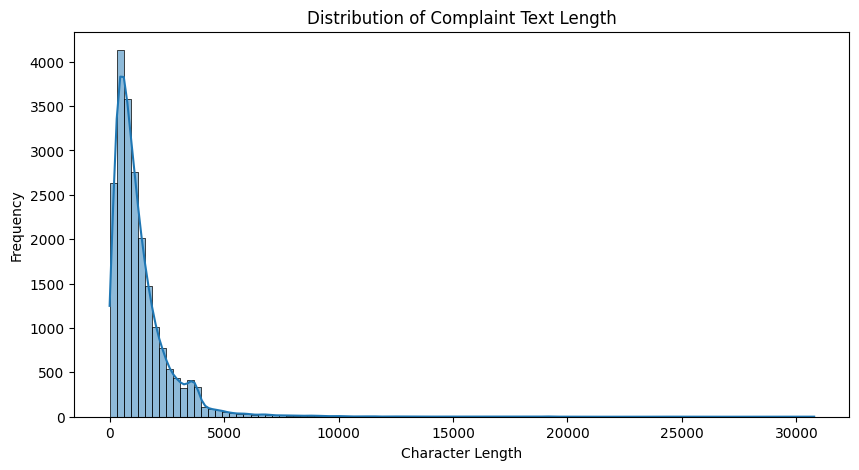

In [206]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_len =pd.DataFrame({"complaint_length": df_clean["complaint"].apply(len)})

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_len["complaint_length"], bins=100, kde=True)
plt.title("Distribution of Complaint Text Length")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

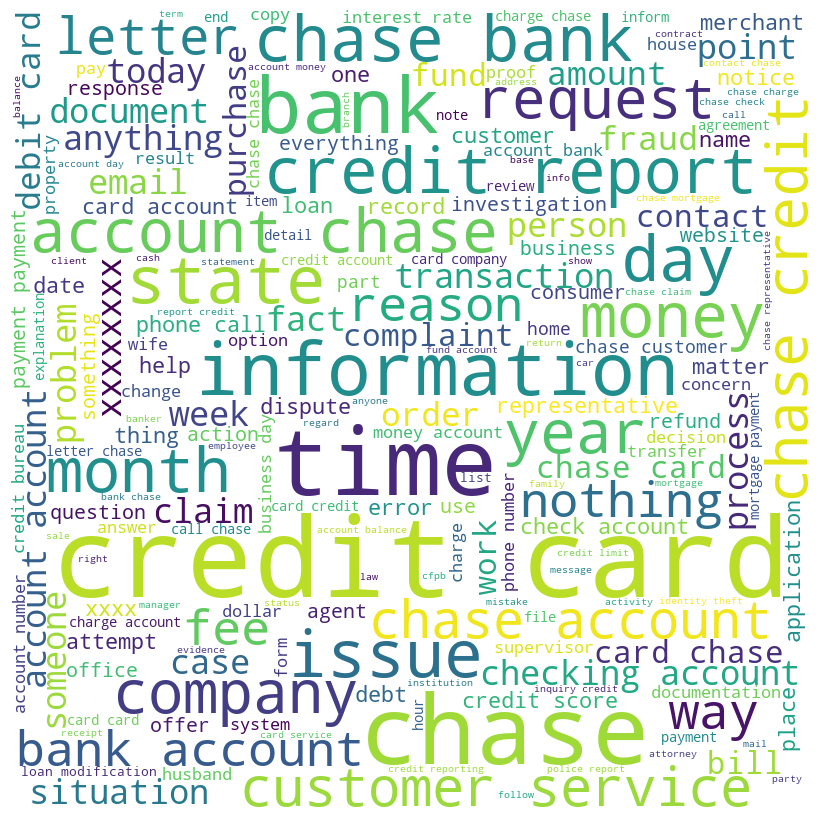

In [207]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
long_string = " ".join(df_clean['complaint_POS_removed'])
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      stopwords = None, 
                      min_font_size = 10).generate(long_string)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


In [208]:
#Removing -PRON- from the text corpus

df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.head(10)

,complaint,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,card agent anniversary date agent information order account anniversary date consent recording a...
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i w...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I g...,notice account debit card branch customer service representative account branch fund deposit pla...,notice account debit card branch customer service representative account branch fund deposit pla...
20,during the summer months i experience a decline income due to my employment therefore i request ...,during the summer month I experience a decline income due to my employment therefore I request a...,summer month decline income employment month payment extension auto loan company chase past year...,summer month decline income employment month payment extension auto loan company chase past year...
21,on xxxx i made a payment to an online retailer using chase quick pay with xxxx on the chase we...,on xxxx I make a payment to an online retailer use chase quick pay with xxxx on the chase we...,payment retailer use chase pay chase website scam website confirmation product response inquiry ...,payment retailer use chase pay chase website scam website confirmation product response inquiry ...
23,i have a chase credit card which is incorrectly reporting data on my credit report the company i...,I have a chase credit card which be incorrectly report datum on my credit report the company be ...,chase credit card report datum credit report company help issue,chase credit card report datum credit report company help issue


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [209]:
from sklearn.feature_extraction.text import CountVectorizer
import heapq

def ngram_freq_vectorizer(df, n, top_n):
    vec = CountVectorizer(ngram_range=(n, n), analyzer='word', stop_words='english', min_df=2, max_df=0.95)
    X = vec.fit_transform(df)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).A1)
    top = heapq.nlargest(top_n, freqs, key=lambda x: x[1])
    return pd.DataFrame(top, columns=['ngram', 'frequency'])

In [210]:
# Function to calculate n-gram frequency for a given column values and return top_n n-grams
def ngram_freq(df, n, top_n):
    a = df.str.split().apply(lambda x : Counter(ngrams(x, n))).sum().most_common(top_n)
    df = pd.DataFrame(a, columns=['ngram_touple', 'frequency'])
    df['ngram'] = df ['ngram_touple'].apply(lambda x : ' '.join(x))
    return df[['ngram','frequency']]

# Function to plot frequency against each terms
def plot_term_frequency(terms, frequencies, title):
    plt.figure(figsize=(10, 6))
    plt.barh(terms, frequencies, color='grey')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.tight_layout()
    plt.show()

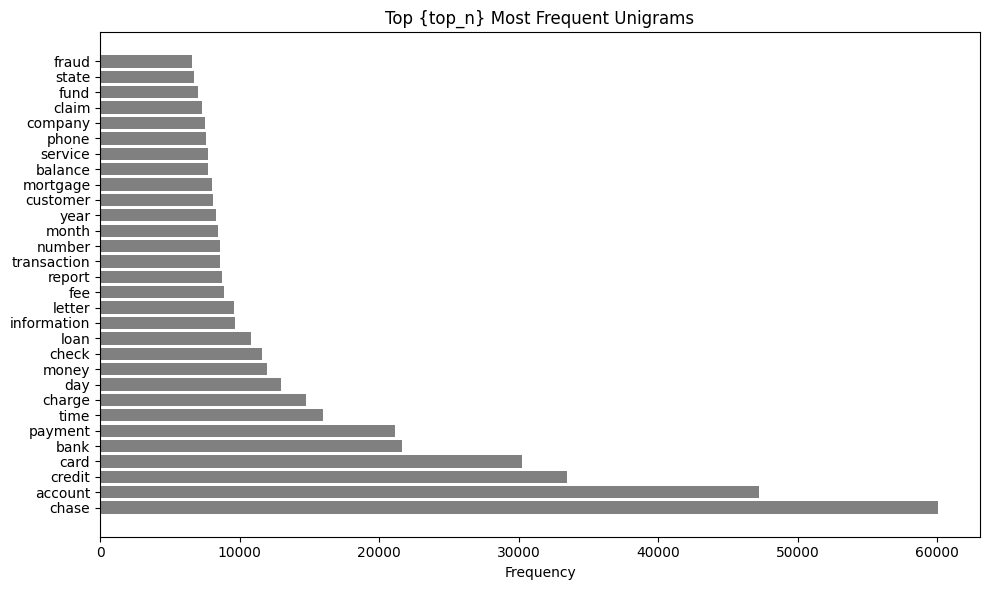

In [211]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_n = 30
unigram_freq = ngram_freq_vectorizer(df_clean['Complaint_clean'], 1, top_n)
plot_term_frequency(unigram_freq['ngram'], unigram_freq['frequency'], "Top {top_n} Most Frequent Unigrams")


In [212]:
#Print the top 10 words in the unigram frequency
unigram_freq[:10]


,ngram,frequency
0,chase,60051
1,account,47225
2,credit,33486
3,card,30264
4,bank,21609
5,payment,21151
6,time,16007
7,charge,14737
8,day,12936
9,money,11929


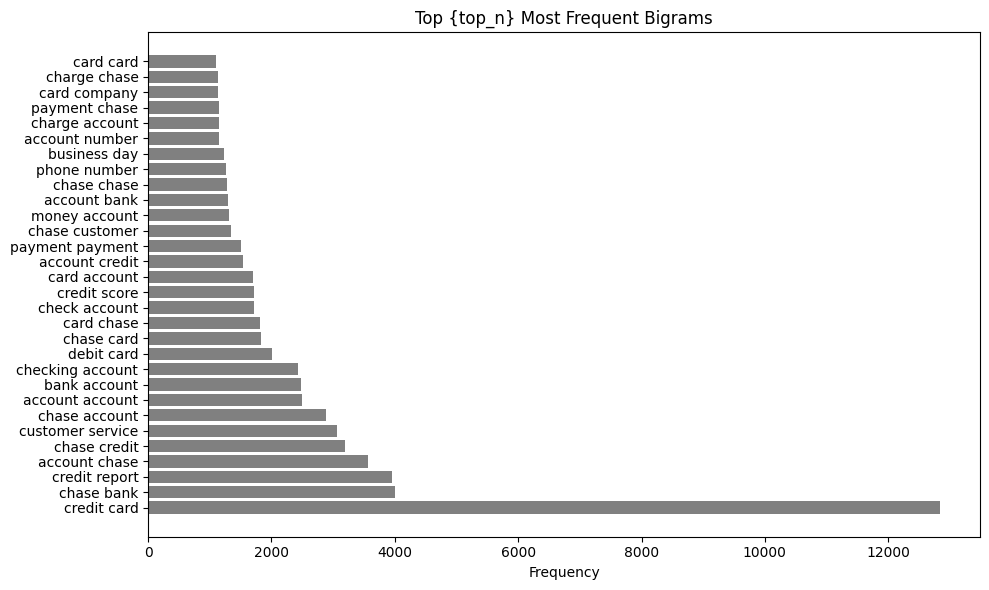

In [213]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_n = 30
bigram_freq = ngram_freq_vectorizer(df_clean['Complaint_clean'], 2, top_n)
plot_term_frequency(bigram_freq['ngram'], bigram_freq['frequency'], "Top {top_n} Most Frequent Bigrams")



In [214]:
#Print the top 10 words in the bigram frequency
bigram_freq[:10]

,ngram,frequency
0,credit card,12846
1,chase bank,4004
2,credit report,3949
3,account chase,3567
4,chase credit,3198
5,customer service,3066
6,chase account,2891
7,account account,2499
8,bank account,2473
9,checking account,2423


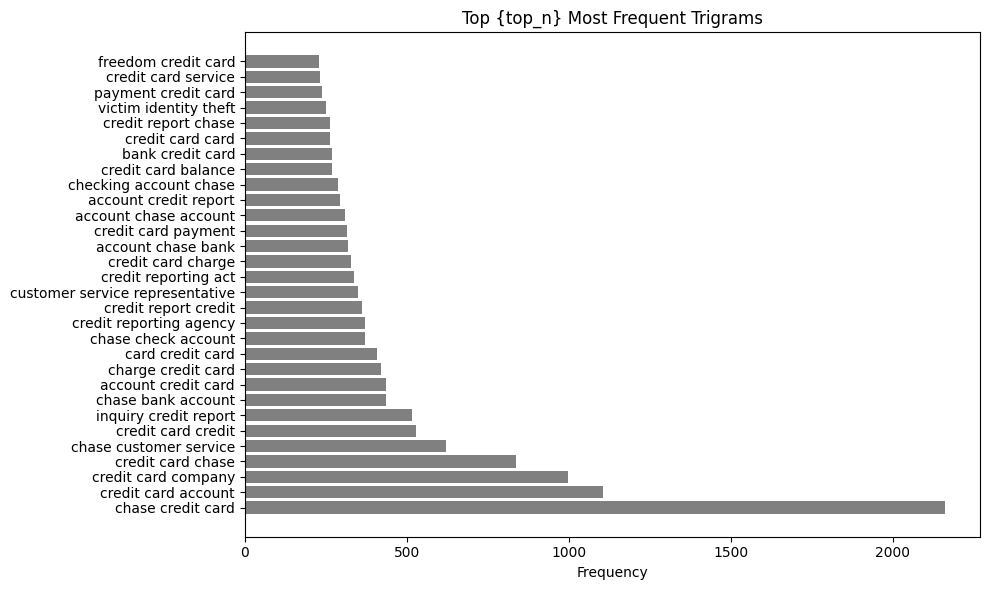

In [215]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_n = 30
trigram_freq = ngram_freq_vectorizer(df_clean['Complaint_clean'], 3, top_n)
plot_term_frequency(trigram_freq['ngram'], trigram_freq['frequency'], "Top {top_n} Most Frequent Trigrams")


In [216]:
#Print the top 10 words in the trigram frequency
trigram_freq[:10]

,ngram,frequency
0,chase credit card,2162
1,credit card account,1106
2,credit card company,998
3,credit card chase,838
4,chase customer service,620
5,credit card credit,529
6,inquiry credit report,517
7,chase bank account,437
8,account credit card,435
9,charge credit card,419


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [217]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [218]:
#All masked texts has been removed
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,card agent anniversary date agent information order account anniversary date consent recording a...
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...
...,...,...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday xxxxxxxx I call chas my xxxx xxxx visa credit card provider and ask how to make a c...,credit card provider claim purchase protection benefit school textbook year daughter school book...,credit card provider claim purchase protection benefit school textbook year daughter school book...
78310,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...
78311,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...,credit chase credit card chase freedom problem balance transfer life plenty experience balance t...,credit chase credit card chase freedom problem balance transfer life plenty experience balance t...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [219]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words='english'
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [220]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

print("DTM shape:", dtm.shape)

DTM shape: (21072, 6767)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [221]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [222]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40, init='nndsvda', max_iter=500)

In [223]:
doc_topic_matrix = nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6767

In [224]:
#Print the Top15 words for each of the topics
top_n =  15
feature_names = tfidf.get_feature_names_out()
for index, topic in enumerate(nmf_model.components_):
    print(f"Topic #: {index}")
    print(", ".join([feature_names[i] for i in topic.argsort()[-top_n:]]), '\n')
    

Topic #: 0
customer, transfer, transaction, business, number, checking, day, branch, deposit, fund, chase, money, bank, check, account 

Topic #: 1
reporting, year, letter, application, information, limit, debt, company, score, account, chase, inquiry, report, card, credit 

Topic #: 2
request, sale, house, foreclosure, time, document, rate, letter, year, property, modification, home, chase, mortgage, loan 

Topic #: 3
refund, email, statement, time, service, claim, fraud, merchant, purchase, dispute, transaction, fee, chase, card, charge 

Topic #: 4
error, year, mortgage, account, credit, date, chase, auto, time, day, statement, fee, month, balance, payment 



In [225]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
doc_topic_matrix = nmf_model.transform(dtm)
doc_topic_matrix.argmax(axis=1)

array([2, 3, 1, ..., 3, 4, 4])

In [226]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = doc_topic_matrix.argmax(axis=1)

In [227]:
df_clean.head()

,complaint,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,morning name stop service debt verification statement bank debt mail month debt right informatio...,2
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,card agent anniversary date agent information order account anniversary date consent recording a...,3
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,0


In [228]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i w...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I g...,notice account debit card branch customer service representative account branch fund deposit pla...,notice account debit card branch customer service representative account branch fund deposit pla...,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,0
27,i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up...,I open an account with chase bank on xxxx and use a code for xxxx bonus I call to follow up on x...,account bank code bonus term everything account deposit bonus day require deposit account coupon...,account bank code bonus term everything account deposit bonus day require deposit account coupon...,0
24,mishandling of this account by chase auto and xxxx,mishandle of this account by chase auto and xxxx,mishandle account auto,mishandle account auto,0
35,i opened the saving account for the bonus i was supposed to received the bonus after consecut...,I open the save account for the bonus I be suppose to received the bonus after consecutive...,save account bonus bonus auto transfer check transfer fund checking account fund account request...,save account bonus bonus auto transfer check transfer fund checking account fund account request...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant,1
26,i have reached out to xxxx several times in attempt to have this fraudulent inquiry removed i wa...,I have reach out to xxxx several time in attempt to have this fraudulent inquiry remove I be tel...,time attempt inquiry remove creditor inquiry report attempt chase bank bureau inquiry person car...,time attempt inquiry remove creditor inquiry report attempt chase bank bureau inquiry person car...,1
23,i have a chase credit card which is incorrectly reporting data on my credit report the company i...,I have a chase credit card which be incorrectly report datum on my credit report the company be ...,chase credit card report datum credit report company help issue,chase credit card report datum credit report company help issue,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [229]:
#Create the dictionary of Topic names and Topics
# Based on keywords and sample data it appears that cluster topic ids maps to below topic names
Topic_id_to_name_mapping = {
    0: "Bank account services",
    1: "Credit card or prepaid card",
    2: "Mortgages/Loans",
    3: "Theft/Dispute reporting",
    4: "Others"
}
#Replace Topics with Topic Names
df_clean['Topic_Name'] = df_clean['Topic'].map(Topic_id_to_name_mapping)

In [230]:
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_Name
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,morning name stop service debt verification statement bank debt mail month debt right informatio...,2,Mortgages/Loans
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,card agent anniversary date agent information order account anniversary date consent recording a...,3,Theft/Dispute reporting
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant,1,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1,Credit card or prepaid card
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,0,Bank account services
...,...,...,...,...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,3,Theft/Dispute reporting
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday xxxxxxxx I call chas my xxxx xxxx visa credit card provider and ask how to make a c...,credit card provider claim purchase protection benefit school textbook year daughter school book...,credit card provider claim purchase protection benefit school textbook year daughter school book...,3,Theft/Dispute reporting
78310,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,3,Theft/Dispute reporting
78311,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...,credit chase credit card chase freedom problem balance transfer life plenty experience balance t...,credit chase credit card chase freedom problem balance transfer life plenty experience balance t...,4,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [231]:
#Create the dictionary again of Topic names and Topics

#Replace Topics names with Topic no
#df_clean['Topic'] = df_clean['Topic'].map(Topic_name_to_id_mapping)

In [232]:
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_Name
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,morning name stop service debt verification statement bank debt mail month debt right informatio...,2,Mortgages/Loans
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,card agent anniversary date agent information order account anniversary date consent recording a...,3,Theft/Dispute reporting
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant,1,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1,Credit card or prepaid card
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,son chase account fund chase bank account money son check money chase bank money son chase time ...,0,Bank account services
...,...,...,...,...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...,3,Theft/Dispute reporting
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday xxxxxxxx I call chas my xxxx xxxx visa credit card provider and ask how to make a c...,credit card provider claim purchase protection benefit school textbook year daughter school book...,credit card provider claim purchase protection benefit school textbook year daughter school book...,3,Theft/Dispute reporting
78310,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,pay risk consumer chase bank app chase year banking merchant merchant inquiry communication webs...,3,Theft/Dispute reporting
78311,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...,credit chase credit card chase freedom problem balance transfer life plenty experience balance t...,credit chase credit card chase freedom problem balance transfer life plenty experience balance t...,4,Others


In [233]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint', 'Topic']]

In [234]:
training_data

,complaint,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,2
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,3
10,chase card was reported on however fraudulent application have been submitted my identity witho...,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,0
...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for ...,3
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,3
78310,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,3
78311,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count
#Write your code here to transform the word vector to tf-idf
y = training_data['Topic'].values

count_vectorizer = CountVectorizer(stop_words='english', min_df=2, max_df=0.95)
count_vector = count_vectorizer.fit_transform(training_data['complaint'])

tfidfTransformer = TfidfTransformer()
tfidf = tfidfTransformer.fit_transform(count_vector)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
target_names = [Topic_id_to_name_mapping[i] for i in sorted(id_to_name)]
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

#Write your code here to transform the word vector to tf-idf

                             precision    recall  f1-score   support

      Bank account services       0.93      0.95      0.94      1020
Credit card or prepaid card       0.93      0.92      0.92       922
            Mortgages/Loans       0.93      0.94      0.93       746
    Theft/Dispute reporting       0.91      0.92      0.91      1079
                     Others       0.94      0.85      0.89       448

                   accuracy                           0.92      4215
                  macro avg       0.93      0.92      0.92      4215
               weighted avg       0.92      0.92      0.92      4215



You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

count_vectorizer = CountVectorizer(stop_words='english', min_df=2, max_df=0.95)
count_vector   = count_vectorizer.fit_transform(training_data['complaint'].fillna(""))

tfidfTransformer  = TfidfTransformer()
tfidf   = tfidfTransformer.fit_transform(count_vector)

y = training_data['Topic'].values

X_train, X_test, y_train, y_test = train_test_split(
    tfidf, y, test_size=0.2, random_state=42, stratify=y
)

label_names = [str(i) for i in sorted(np.unique(y))]
models = {
    "DecisionTreeModel": DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        class_weight='balanced',
        random_state=42
    ),
    "RandomForestModel": RandomForestClassifier(
        n_estimators=300,
        n_jobs=-1,
        class_weight='balanced_subsample',
        random_state=42
    ),
    "LinearSVMModel": LinearSVC(
        class_weight='balanced',
        random_state=42
    )
}

rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"****** {name} ******")
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    rows.append({
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted
    })

summary = pd.DataFrame(rows).sort_values("f1_macro", ascending=False)
print("****** Summary (higher is better) ******")
print(summary)



****** DecisionTreeModel ******
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1020
           1       0.80      0.81      0.80       922
           2       0.81      0.81      0.81       746
           3       0.78      0.75      0.76      1079
           4       0.77      0.77      0.77       448

    accuracy                           0.79      4215
   macro avg       0.79      0.79      0.79      4215
weighted avg       0.79      0.79      0.79      4215

